In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
pd.options.display.float_format = '{:.4f}'.format
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
%load_ext autoreload
%autoreload 2
%matplotlib inline

from perturbseq import *

# Load pre-processed Perturbseq experiment from hdf5

Populations are constructed in notebook *GI generate populations*

In [2]:
pop = CellPopulation.from_hdf('/home/tmn/sequencing/gi/gi/outs/final_single_cell_pop_with_normalized.hdf')

Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 31.6935930252s.
Done.


In [3]:
pop.info()

Matrix
<class 'pandas.core.frame.DataFrame'>
Index: 93658 entries, AAACCTGAGGCATGTG-1 to TTTGTCATCTGGCGAC-8
Columns: 24665 entries, ENSG00000243485 to ENSG00000271254
dtypes: int32(24665)
memory usage: 8.6 GB

Normalized matrix
<class 'pandas.core.frame.DataFrame'>
Index: 93658 entries, AAACCTGAGGCATGTG-1 to TTTGTCATCTGGCGAC-8
Columns: 24665 entries, ENSG00000243485 to ENSG00000271254
dtypes: float64(24665)
memory usage: 17.2 GB


In [4]:
control_pop = CellPopulation.from_hdf('/home/tmn/sequencing/gi/gi/outs/control_pop.hdf')

Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 2.52955102921s.
Done.


In [5]:
mean_pop = CellPopulation.from_hdf('/home/tmn/sequencing/gi/gi/outs/mean_pop_with_normalized.hdf')

Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 0.191696166992s.
Done.


# Load emap information

In [6]:
# these have different names in the emap and in GChr38
name_replacer = {'C3orf72': 'FOXL2NB',
                 'C19orf26': 'CBARP',
                 'KIAA1804': 'RP5-862P8.2',
                 'RHOXF2': 'RHOXF2B',
                }

inverse_name_replacer = {v: k for k, v in name_replacer.iteritems()}

In [7]:
emap = pd.read_csv('./final_emaps/processed_emap.csv', index_col=[0])
phen_matrix = pd.read_csv('./final_emaps/processed_fitnesses.csv', index_col=[0])
single_phen = pd.read_csv('./final_emaps/single_fitnesses.csv', index_col=[0])

In [8]:
# this is average fitness across two guides in primary emap, not single guide used for perturbseq
single_fitnesses = single_phen['average_fitness']

# fitness mapper, maps names to raw fitness values
fitness_mapper = dict()
for perturbation in pop.cells['guide_target'].unique():
    first, second = perturbation.split('_')
    try:
        if 'NegCtrl' in second:
            fitness_mapper[perturbation] = single_fitnesses.loc[first]
        elif 'NegCtrl' in first:
            fitness_mapper[perturbation] = single_fitnesses.loc[second]
        else:
            fitness_mapper[perturbation] = phen_matrix.loc[first, second]
    except KeyError:
        fitness_mapper[perturbation] = np.nan

In [9]:
single_genes = np.intersect1d(reduce(np.union1d, mean_pop.cells.query('num_targets == 1')['guide_target'].map(lambda x: x.split('_'))),
               emap.columns.map(lambda x: name_replacer.get(x, x)))
# we know these don't work...
single_genes = np.setdiff1d(single_genes, ['BAK1', 'BCL2L11'])

# maps gene name to single (SLC38A2 is the lone exception where we don't have it in position 1)
single_gene_perturbations = dict()

for gene in single_genes:
    if gene + '_NegCtrl0' in mean_pop.cells.index:
        single_gene_perturbations[gene] = gene + '_NegCtrl0'
    elif 'NegCtrl0_' + gene in mean_pop.cells.index:
        single_gene_perturbations[gene] = 'NegCtrl0_' + gene
        
double_perturbations = mean_pop.cells.query('num_targets == 2').index
perturbations = single_gene_perturbations.values()

for p in double_perturbations:
    gene1, gene2 = p.split('_')
    if gene1 in single_genes and gene2 in single_gene_perturbations.keys():
        perturbations.append(p)
        
fitnesses = mean_pop.cells.loc[perturbations, 'fitness']

mapper = {v: k for k, v in single_gene_perturbations.iteritems()}

# Finding differentially expressed genes

In [10]:
ks, ps, adj_ps = ks_de(pop,
                       key='guide_target',
                       control_cells='perturbed == "control"',
                       genes='mean > 0.5',
                       normalized=True,
                       alpha=0.001,
                       n_jobs=24)

7353 control cells
groupby: index in @key_barcodes (key = guide_target)


[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    4.1s
[Parallel(n_jobs=24)]: Done  13 tasks      | elapsed:    7.5s
[Parallel(n_jobs=24)]: Done  24 tasks      | elapsed:   11.1s
[Parallel(n_jobs=24)]: Done  37 tasks      | elapsed:   16.3s
[Parallel(n_jobs=24)]: Done  50 tasks      | elapsed:   22.8s
[Parallel(n_jobs=24)]: Done  65 tasks      | elapsed:   30.4s
[Parallel(n_jobs=24)]: Done  80 tasks      | elapsed:   36.6s
[Parallel(n_jobs=24)]: Done  97 tasks      | elapsed:   41.6s
[Parallel(n_jobs=24)]: Done 114 tasks      | elapsed:   47.0s
[Parallel(n_jobs=24)]: Done 133 tasks      | elapsed:   53.4s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:   59.4s
[Parallel(n_jobs=24)]: Done 173 tasks      | elapsed:  1.1min
[Parallel(n_jobs=24)]: Done 194 tasks      | elapsed:  1.2min
[Parallel(n_jobs=24)]: Done 217 tasks      | elapsed:  1.4min
[Parallel(n_jobs=24)]: Done 240 tasks      | elapsed:  1.5min
[Parallel(n_jobs=24)]: Done 269 out of 287 | elapsed:  1.7min remainin

In [11]:
mean_pop.cells['ks_de'] = (adj_ps < 0.001).sum()

# Fitting linear interaction model

This is the routine that is used to fit the linear interaction model. It simultaneously calculates a number of other statistics. See Table S9 of the paper for descriptions.

In the paper the model was fit by robust regression using the Theil-Sen estimator. This is quite slow. The code below also fits a robust linear model using statsmodels that gives similar coefficients and is much faster.

In [12]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, TheilSenRegressor
from dcor import distance_correlation, partial_distance_correlation
from sklearn.metrics import r2_score

def calc_corr_stats(first, second, double, variable_genes):
    out = dict()
    
    singles_expr = matrix.loc[[first, second], variable_genes].T.values
    first_expr = matrix.loc[first, variable_genes].values.reshape(-1, 1)
    second_expr = matrix.loc[second, variable_genes].values.reshape(-1, 1)
    double_expr = matrix.loc[double, variable_genes].values.reshape(-1, 1)
    
    regr = LinearRegression(fit_intercept=False)
    ts = TheilSenRegressor(fit_intercept=False,
                          max_subpopulation=1e5,
                          max_iter=1000,
                          random_state=1000)    
    X = singles_expr
    y = double_expr
    regr.fit(X, y)
    ts.fit(X, y.ravel())
    rlm = sm.RLM(y.ravel(), X, M=sm.robust.norms.TukeyBiweight()).fit()
    Z = regr.predict(X)
    Zts = ts.predict(X)
    Zrlm = rlm.fittedvalues
    
    out['de_double'] = np.log10(mean_pop.cells.loc[double, 'ks_de'])
    out['de_first'] = np.log10(mean_pop.cells.loc[first, 'ks_de'])
    out['de_second'] = np.log10(mean_pop.cells.loc[second, 'ks_de'])
    out['dcor'] = distance_correlation(singles_expr, double_expr)
    out['dcor_singles'] = distance_correlation(first_expr, second_expr)
    out['ts_linear_dcor'] = distance_correlation(double_expr, Zts.reshape(-1, 1))
    out['corr_first'] = np.corrcoef(first_expr.flatten(), double_expr.flatten())[0,1]
    out['corr_second'] = np.corrcoef(second_expr.flatten(), double_expr.flatten())[0,1]
    out['corr_sum'] = np.corrcoef((first_expr + second_expr).flatten(), double_expr.flatten())[0,1]
    out['corr_fit'] = np.corrcoef(Z.flatten(), double_expr.flatten())[0,1]
    out['corr_first_second'] = pd.Series(first_expr.flatten()).corr(pd.Series(second_expr.flatten()), method='spearman')
    out['name'] = double
    out['coef_first'] = regr.coef_[0][0]
    out['coef_second'] = regr.coef_[0][1]
    out['score'] = regr.score(X, y)
    out['ts_coef_first'] = ts.coef_[0]
    out['ts_coef_second'] = ts.coef_[1]  
    out['ts_score'] = ts.score(X, y)
    out['rlm_coef_first'] = rlm.params[0]
    out['rlm_coef_second'] = rlm.params[1]
    out['UMI_first'] = mean_pop.cells.loc[first, 'UMI_count']
    out['UMI_second'] = mean_pop.cells.loc[second, 'UMI_count']
    out['UMI_double'] = mean_pop.cells.loc[double, 'UMI_count']
    return out

/home/tmn/.local/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Choose genes that are used for fitting linear model ("abundant" genes = mean expression > 0.5). We then only fit the model to perturbations where doubly perturbed cells have at least 10 differentially expressed genes abundant genes.

In [13]:
perturbation_ids = pop.gene_ids(np.union1d(mean_pop.cells['first_target'], mean_pop.cells['second_target']))
abundant_genes = np.setdiff1d(pop.genes.query('mean > 0.5').index.values, perturbation_ids)

doubles = list()
# this will for example remove BCL2L11 and BAK1 doubles which we know are broken
for idx, row in mean_pop.cells.loc[perturbations].query('num_targets == 2').iterrows():
    first = row['first_target'] + '_NegCtrl0'
    second = 'NegCtrl0_' + row['second_target']
    if (first in mean_pop.cells.index) and (second in mean_pop.cells.index):
        doubles.append((first, second, idx))
        
gene_lists = [(first, second, double, abundant_genes) for first, second, double in doubles
               if ((adj_ps[double] < 0.001).sum() > 10)]

Now fit the model

In [14]:
from joblib import Parallel, delayed

matrix = mean_pop.normalized_matrix

out = Parallel(n_jobs=24, verbose=10)(delayed(calc_corr_stats)(*double) for double in gene_lists)

/home/tmn/.local/lib/python2.7/site-packages/dcor/_utils.py:88: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return ((np.issubdtype(x.dtype, float) and
/home/tmn/.local/lib/python2.7/site-packages/dcor/_utils.py:88: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return ((np.issubdtype(x.dtype, float) and
/home/tmn/.local/lib/python2.7/site-packages/dcor/_utils.py:88: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return ((np.issubdtype(x.dtype, float) and
/home/tmn/.local/lib/python2.7/site-packages/dcor/_utils.py:88: FutureWarning: Conversion of the second argument of issubdtype from `flo

A bunch of fiddling to make various derived statistics. A subset of the resulting table is Table S9 from the paper.

In [15]:
regr_fits = pd.DataFrame(out).set_index('name')

regr_fits['ts_ratio'] = regr_fits['ts_coef_first']/regr_fits['ts_coef_second']
regr_fits['ts_difference'] = regr_fits['ts_coef_first'] - regr_fits['ts_coef_second']
regr_fits['abs_log_ts_ratio'] = np.log10(np.abs(regr_fits['ts_coef_first'])/np.abs(regr_fits['ts_coef_second'])).abs()
regr_fits['ts_norm'] = regr_fits.apply(lambda x: np.mean([np.abs(x['ts_coef_first']), np.abs(x['ts_coef_second'])]), axis=1)

regr_fits['rlm_ratio'] = regr_fits['rlm_coef_first']/regr_fits['rlm_coef_second']
regr_fits['abs_log_rlm_ratio'] = np.log10(np.abs(regr_fits['rlm_coef_first'])/np.abs(regr_fits['rlm_coef_second'])).abs()
regr_fits['rlm_norm'] = regr_fits.apply(lambda x: np.mean([np.abs(x['rlm_coef_first']), np.abs(x['rlm_coef_second'])]), axis=1)

regr_fits['rlm_norm2'] = regr_fits.apply(lambda x: np.sqrt(x['rlm_coef_first']**2 + x['rlm_coef_second']**2), axis=1)
regr_fits['ts_norm2'] = regr_fits.apply(lambda x: np.sqrt(x['ts_coef_first']**2 + x['ts_coef_second']**2), axis=1)
regr_fits['coef_norm2'] = regr_fits.apply(lambda x: np.sqrt(x['coef_first']**2 + x['coef_second']**2), axis=1)

emap_values = dict()
phen_values = dict()
for double in regr_fits.index:
    first, second = double.split('_')
    try:
        emap_values[double] = emap.loc[first, second]
        phen_values[double] = phen_matrix.loc[first, second]
    except KeyError:
        emap_values[double] = np.nan
        phen_values[double] = np.nan
        
regr_fits['emap'] = pd.Series(emap_values)
regr_fits['fitness'] = pd.Series(phen_values)
regr_fits = regr_fits.replace({np.inf: 0, -np.inf: 0})

A number of these features are strongly correlated with each other...

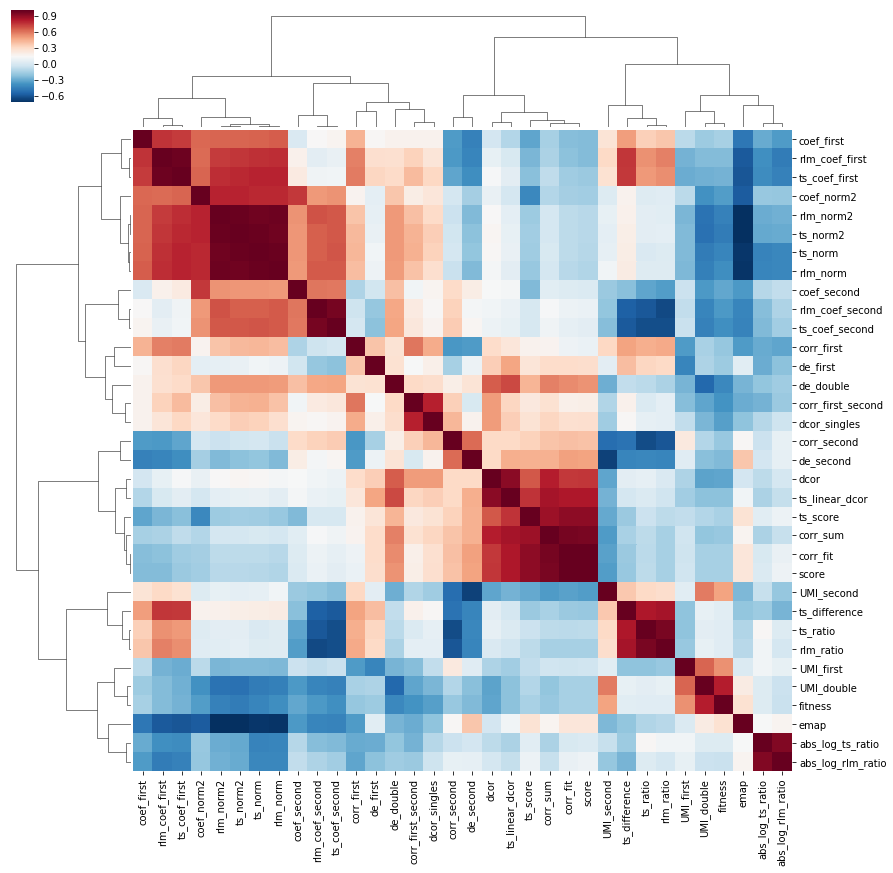

In [16]:
sns.clustermap(regr_fits.corr(), method='ward', figsize=[14,14], cmap=plt.cm.get_cmap('RdBu_r'), yticklabels=True)

What correlates best with fitness GI map score?

In [17]:
regr_fits.corr()['emap'].sort_values()

ts_norm2            -0.7172
rlm_norm2           -0.7128
rlm_norm            -0.6989
ts_norm             -0.6952
ts_coef_first       -0.5933
rlm_coef_first      -0.5786
coef_norm2          -0.5716
coef_first          -0.4795
ts_coef_second      -0.4305
rlm_coef_second     -0.4244
coef_second         -0.3490
corr_first          -0.3467
corr_first_second   -0.2843
de_double           -0.2570
UMI_second          -0.2473
dcor_singles        -0.2051
ts_difference       -0.1995
ts_ratio            -0.1160
rlm_ratio           -0.0987
dcor                -0.0132
UMI_first            0.0199
de_first             0.0415
ts_linear_dcor       0.1132
abs_log_ts_ratio     0.1355
corr_second          0.1525
abs_log_rlm_ratio    0.1649
corr_sum             0.1678
UMI_double           0.2151
score                0.2436
corr_fit             0.2486
ts_score             0.2627
fitness              0.2690
de_second            0.3782
emap                 1.0000
Name: emap, dtype: float64

# Looking for interactions that are driven by direct regulatory control

One could imagine that some GIs arise from direct regulatory interactions where for example gene B is a direct target of gene A. Fig. S11G looks for these effects.

In [18]:
first_position_differences = dict()
second_position_differences = dict()
relative_first_position_differences = dict()
relative_second_position_differences = dict()
first_position_expr_differences = dict()
second_position_expr_differences = dict()

for first, second, double in doubles:
    first_id = pop.gene_ids(first.split('_')[0])
    second_id = pop.gene_ids(second.split('_')[1])
    first_position_differences[double] = mean_pop.cells.loc[double, 'fold_first_expr']/mean_pop.cells.loc[first, 'fold_first_expr']
    relative_first_position_differences[double] = first_position_differences[double]*mean_pop.cells.loc[first, 'UMI_count']/mean_pop.cells.loc[double, 'UMI_count']
    second_position_differences[double] = mean_pop.cells.loc[double, 'fold_second_expr']/mean_pop.cells.loc[second, 'fold_second_expr']
    relative_second_position_differences[double] = second_position_differences[double]*mean_pop.cells.loc[second, 'UMI_count']/mean_pop.cells.loc[double, 'UMI_count']
    first_position_expr_differences[double] = (mean_pop.normalized_matrix.loc[double, first_id] - mean_pop.normalized_matrix.loc[first, first_id])/mean_pop.normalized_matrix.loc[first, first_id]
    second_position_expr_differences[double] = (mean_pop.normalized_matrix.loc[double, second_id] - mean_pop.normalized_matrix.loc[second, second_id])/mean_pop.normalized_matrix.loc[second, second_id]
    
first_position_differences = np.log10(pd.Series(first_position_differences)).replace({-np.inf: np.nan, np.inf: np.nan}).dropna()
second_position_differences = np.log10(pd.Series(second_position_differences)).replace({-np.inf: np.nan, np.inf: np.nan}).dropna()
relative_first_position_differences = np.log10(pd.Series(relative_first_position_differences)).replace({-np.inf: np.nan, np.inf: np.nan}).dropna()
relative_second_position_differences = np.log10(pd.Series(relative_second_position_differences)).replace({-np.inf: np.nan, np.inf: np.nan}).dropna()
first_position_expr_differences = pd.Series(first_position_expr_differences).replace({-np.inf: np.nan, np.inf: np.nan}).dropna()
second_position_expr_differences = pd.Series(second_position_expr_differences).replace({-np.inf: np.nan, np.inf: np.nan}).dropna()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10


In [19]:
df = pd.DataFrame([first_position_differences, second_position_differences,
                   relative_first_position_differences, relative_second_position_differences,
                  first_position_expr_differences, second_position_expr_differences],
                 index=['fold_first_pos', 'fold_second_pos', 
                        'relative_fold_first_pos', 'relative_fold_second_pos', 
                        'norm_expr_diff_first_pos', 'norm_expr_diff_second_pos']).T
df['emap'] = regr_fits['emap']

df['first_outlier'] = df['relative_fold_first_pos'].abs() > 0.3
df['second_outlier'] = df['relative_fold_second_pos'].abs() > 0.3

In [20]:
def figure_styles():

    sns.set(font_scale=1.)

    SMALL_SIZE = 12
    MEDIUM_SIZE = 14
    BIGGER_SIZE = 18

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    sns.set_style('white')

figure_styles()

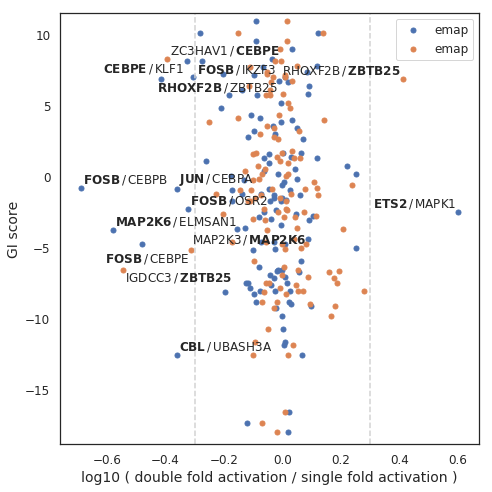

In [21]:
from adjustText import adjust_text

plt.figure(figsize=[7, 7])
plt.scatter(df['relative_fold_first_pos'], df['emap'], s=25)
plt.scatter(df['relative_fold_second_pos'], df['emap'], s=25)
plt.plot([0.3, 0.3], [df['emap'].min()*1.05, df['emap'].max()*1.05], 'lightgray', linestyle='--')
plt.plot([-0.3, -0.3], [df['emap'].min()*1.05, df['emap'].max()*1.05], 'lightgray', linestyle='--')

plt.xlabel('log10 ( double fold activation / single fold activation )')
plt.ylabel('GI score')
plt.tight_layout()

texts = list()
for name, row in df.query('first_outlier').iterrows():
    texts.append(plt.text(row['relative_fold_first_pos'], row['emap'],
                          '$\mathbf{{{0}}}\/ / \/\mathrm{{{1}}}$'.format(*name.split('_')), fontsize=12))
for name, row in df.query('second_outlier').iterrows():
    texts.append(plt.text(row['relative_fold_second_pos'], row['emap'],
                          '$\mathrm{{{0}}}\/ / \/\mathbf{{{1}}}$'.format(*name.split('_')), fontsize=12))

plt.ylim([df['emap'].min()*1.05, df['emap'].max()*1.05])
plt.legend()    
adjust_text(texts, lim=100)

plt.savefig('./figures/epistasis_target_expression.pdf');